In [1]:
import numpy as np

import math
import matplotlib
import matplotlib.pyplot as plt

from scipy import signal
import colorsys
from os import listdir
%matplotlib inline
import scipy.misc

In [2]:
import random
PERCENT_MIN=0.004
PERCENT_MAX=0.01
def createRandomMask(height,width,numberofrect=3):
    mask=np.zeros((height,width))
    rects=[]
    for rect in range(numberofrect) :
        k_0=random.randint(0,height)
        p_0=random.randint(0,width)
        k_1=random.randint(0,height-k_0)+k_0
        p_1=random.randint(0,width-p_0)+p_0
        while (p_1-p_0)*(k_1-k_0)>PERCENT_MAX*height*width or (p_1-p_0)*(k_1-k_0)<PERCENT_MIN*height*width  :
            k_0=random.randint(0,height)
            p_0=random.randint(0,width)
            k_1=random.randint(0,height-k_0)+k_0
            p_1=random.randint(0,width-p_0)+p_0 
        mask[k_0:k_1,p_0:p_1]=1
        rects.append([k_0,k_1,p_0,p_1])
    return mask,rects
def createRandomMaskCV(height,width,numberofrect=3):
    mask=np.zeros((height,width),dtype=np.uint8)
    rects=[]
    for rect in range(numberofrect) :
        k_0=random.randint(0,height)
        p_0=random.randint(0,width)
        k_1=random.randint(0,height-k_0)+k_0
        p_1=random.randint(0,width-p_0)+p_0
        while (p_1-p_0)*(k_1-k_0)>PERCENT_MAX*height*width or (p_1-p_0)*(k_1-k_0)<PERCENT_MIN*height*width  :
            k_0=random.randint(0,height)
            p_0=random.randint(0,width)
            k_1=random.randint(0,height-k_0)+k_0
            p_1=random.randint(0,width-p_0)+p_0 
        mask[k_0:k_1,p_0:p_1]=255
        rects.append([k_0,k_1,p_0,p_1])
    return mask,rects


(380L, 740L, 3L)


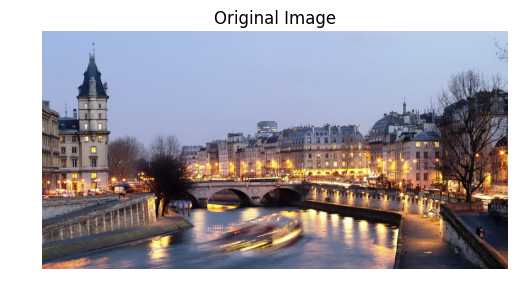

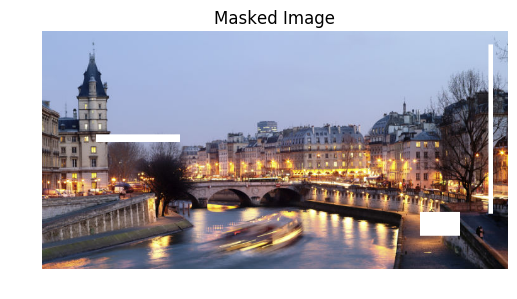

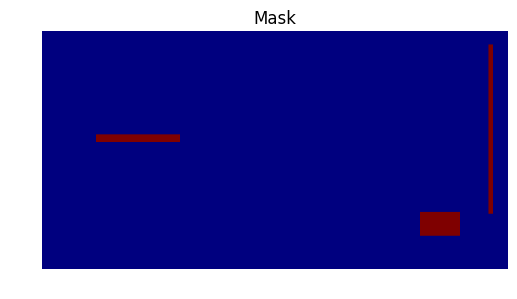

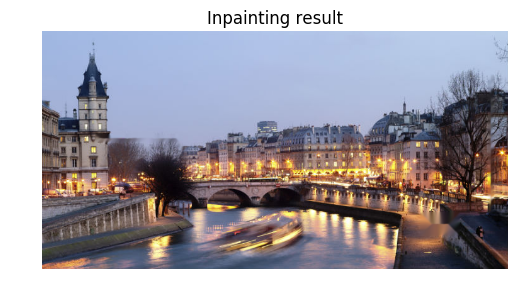

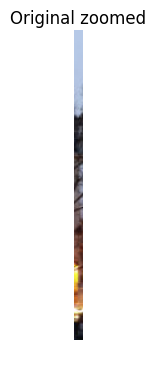

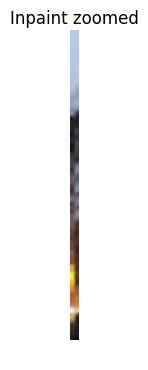

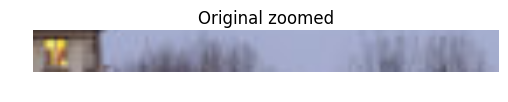

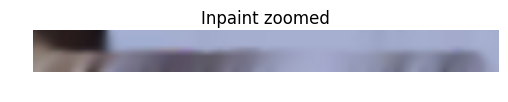

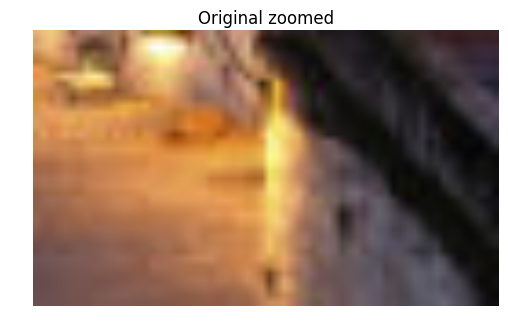

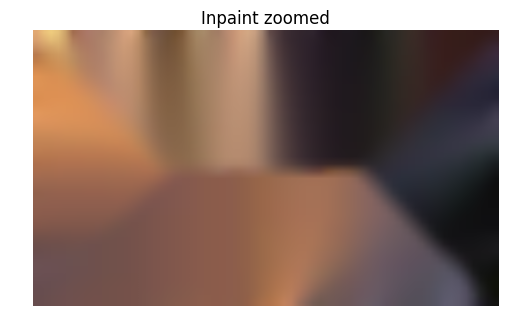

In [3]:
import cv2
from PIL import Image

path=u'./Images/'
onlypics = [path+f for f in listdir(path) if f[-4:]=='.jpg' and 'Mask' not in f]
for fname in onlypics[1:2] :
    image = Image.open(fname)
    arr = np.asarray(image)
    print(arr.shape)
    plt.imshow(arr)
    plt.axis('off')
    plt.title('Original Image')

    
    plt.show()
    mask,rects=createRandomMaskCV(arr.shape[0],arr.shape[1])
    arrmasked=np.copy(arr)
    for j in range(len(rects)) :
        arrmasked[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]]=np.array([255,255,255],dtype=np.uint8)
    plt.imshow(arrmasked)
    plt.title('Masked Image')
    plt.axis('off')
    plt.show()
    dst=cv2.inpaint(arr,mask,3,cv2.INPAINT_NS)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    plt.show()
    plt.imshow(dst)
    plt.title('Inpainting result')
    plt.axis('off')
    plt.show()
    
    
    for j in range(len(rects)) :
        
        plt.imshow(arr[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]])
        plt.title('Original zoomed')
        plt.axis('off')
        plt.show()
        plt.imshow(dst[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]])
        plt.title('Inpaint zoomed')
        plt.axis('off')
        plt.show()
        

In [4]:
def square_intersect_mask(square,mask):
    """
    Parameters
    ------
    
    square = array-like [X_1,X_2,Y_1,Y_2]
    mask=array-like - Image [height,width] with value 255 for concerned mask 
    
    """
    return 255 in mask[square[0]:square[1],square[2]:square[3]]


In [5]:
from sklearn.base import BaseEstimator
import cv2
class Inpaintingmachines(BaseEstimator):    
    """
    Inpaintingmachines for COBRA usage
    Parameters
    ----------
    inpaint: 
        Which opencv inpaint is chosen
    """

    def __init__(self, inpaint=cv2.INPAINT_TELEA,inpaint_radius=3):
        self.inpaint = inpaint
        self.inpaint_radius=inpaint_radius

    def fit(self, X, mask, square_size=40):
        """
        Idea - build a training set for the machines based on the image X - predict value for each pixel out of the mask using
        a new mask made of the previous one and a square.
        Parameters
        ----------
        X: array-like, image [height, width]
            The masked image that will be used to train some data.
        mask: array-like, image = [height, width]
            Same size as X - mask position (0 or 255).
        square_size : int
            Size of the square that we will add to compute prediction for the known values
        """
        ## Original inpaint
        height,width=X.shape[:2]
        prediction=np.zeros(X.shape,dtype=np.uint8)
        inpaint=cv2.inpaint(X,mask,self.inpaint_radius,self.inpaint)
        ## This is the test value but we put them in the prediction.
        for j in range(len(mask)):
            for k in range(len(mask[j])):
                prediction[j,k]=inpaint[j,k]
        
        
        square=[0,square_size,0,square_size]
        while square[1]<height :
            while square[3]<width :
                ##do stuff
                
                ## If square intersects mask, prediction == True value for the pixel out of the mask
                if square_intersect_mask(square,mask) :
                    for j in range(square_size):
                        for k in range(square_size):
                            if mask[j,k]==0 :
                                prediction[j,k]=X[j,k]
                ## Else create the new mask and compute the prediction
                else :
                    newmask=np.copy(mask)
                    newmask[square[0]:square[1],square[2]:square[3]]=255
                    newinpaint=cv2.inpaint(X,newmask,self.inpaint_radius,self.inpaint)
                    prediction[square[0]:square[1],square[2]:square[3]]=newinpaint[square[0]:square[1],square[2]:square[3]]
                
                square[2]+=square_size
                square[3]+=square_size
            
            
            square[2]=0
            square[3]=square_size
            square[1]+=square_size
            square[0]+=square_size
        self.prediction=prediction
        self.mask=mask
        self.X=X
        self.inpaint=inpaint

        return self
    def predict(self,X):
        result=np.zeros(len(X))
        index=0
        for vector in X:
            result[index]=self.prediction[vector[0],vector[1]]
            index+=1
        return result
test=Inpaintingmachines(inpaint=cv2.INPAINT_NS)
test.fit(arr,mask,10)


Inpaintingmachines(inpaint=array([[[160, 185, 226],
        [160, 185, 226],
        ...,
        [184, 208, 236],
        [189, 206, 226]],

       [[160, 185, 226],
        [160, 185, 226],
        ...,
        [184, 208, 236],
        [189, 206, 226]],

       ...,
       [[188, 115,  74],
        [171,  99,  59],
        ...,
        [ 83,  45,  36],
        [ 79,  52,  45]],

       [[204, 122,  98],
        [186, 106,  83],
        ...,
        [ 70,  43,  34],
        [ 66,  49,  42]]], dtype=uint8),
          inpaint_radius=3)

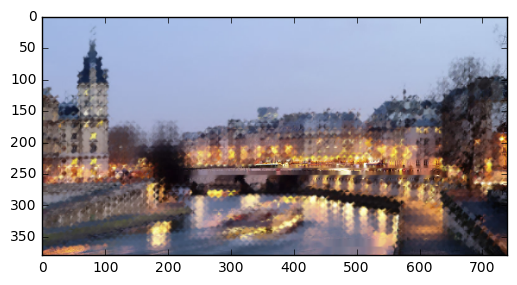

In [7]:
plt.imshow(test.prediction)

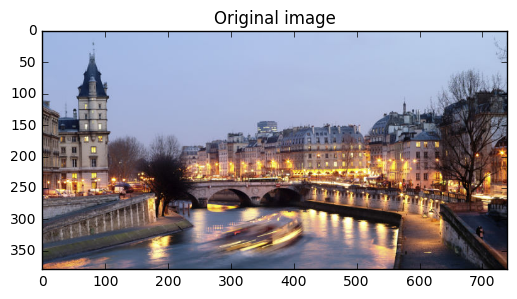

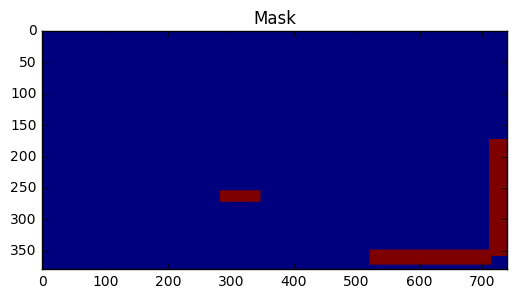

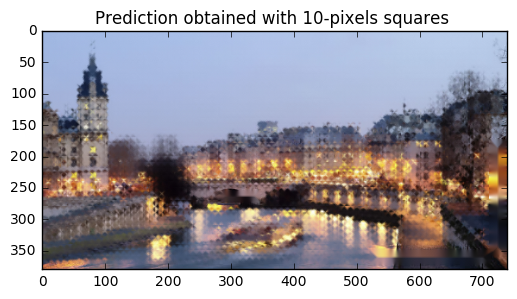

In [54]:
plt.imshow(arr)
plt.title('Original image')
plt.show()
plt.imshow(mask)
plt.title('Mask')
plt.show()
plt.imshow(test.prediction)
plt.title('Prediction obtained with 10-pixels squares ')

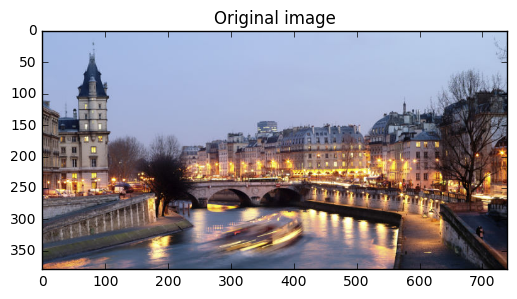

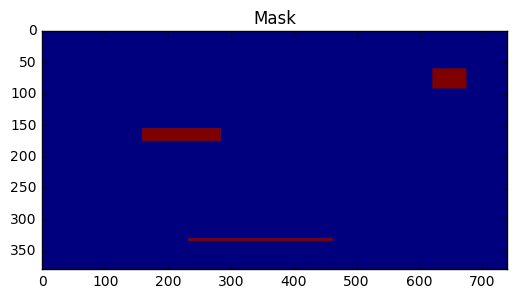

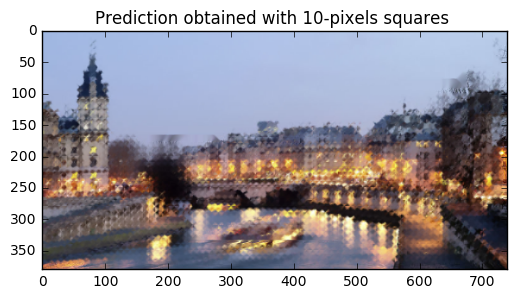

In [61]:
plt.imshow(arr)
plt.title('Original image')
plt.show()
plt.imshow(mask)
plt.title('Mask')
plt.show()
plt.imshow(test2.prediction)
plt.title('Prediction obtained with 10-pixels squares ')

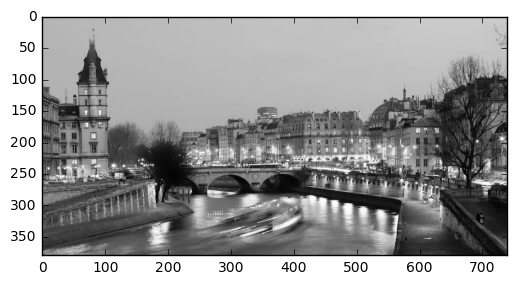

In [80]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def transformimages(im):
    newim=np.zeros(im.shape[:2])
    for j in range(im.shape[0]) :
        for k in range(im.shape[1]):
            newim[j,k]=rgb2gray(im[j,k])
    return newim
plt.imshow(transformimages(arr),cmap='gray')

In [7]:

path=u'./Images/lena.pgm'
image = Image.open(path)
arr = np.asarray(image)

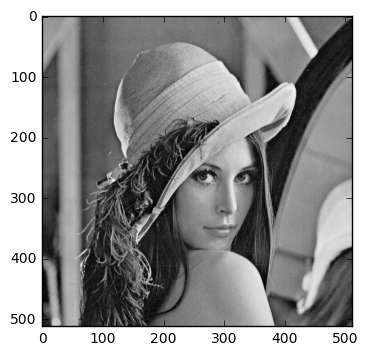

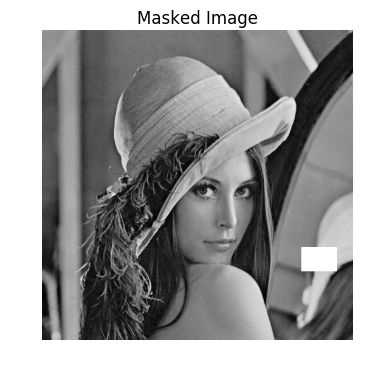

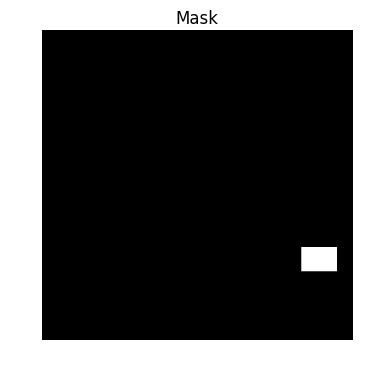

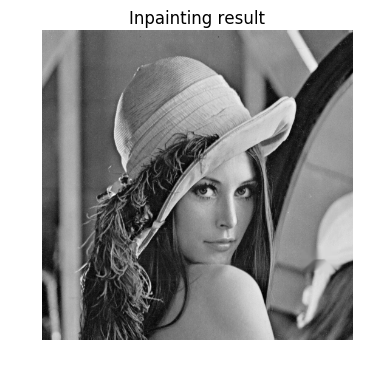

In [20]:
plt.imshow(arr,cmap='gray')
mask,rects=createRandomMaskCV(arr.shape[0],arr.shape[1],1)
plt.show()
arrmasked=np.copy(arr)
for j in range(len(rects)) :
    arrmasked[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]]=np.array(255,dtype=np.uint8)
plt.imshow(arrmasked,cmap='gray')
plt.title('Masked Image')
plt.axis('off')
plt.show()
dst=cv2.inpaint(arr,mask,3,cv2.INPAINT_NS)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()
plt.imshow(dst,cmap='gray')
plt.title('Inpainting result')
plt.axis('off')
plt.show()

In [21]:
test=Inpaintingmachines(inpaint=cv2.INPAINT_NS)
test.fit(arr,mask,10)

Inpaintingmachines(inpaint=array([[162, 162, ..., 155, 128],
       [162, 162, ..., 155, 128],
       ...,
       [ 44,  44, ..., 105, 108],
       [ 44,  44, ..., 105, 108]], dtype=uint8),
          inpaint_radius=3)

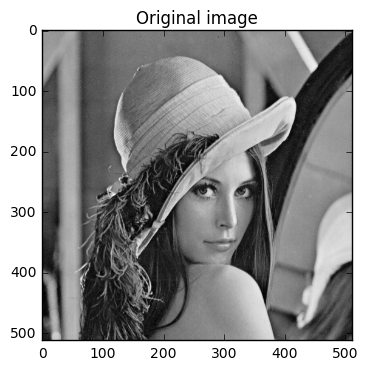

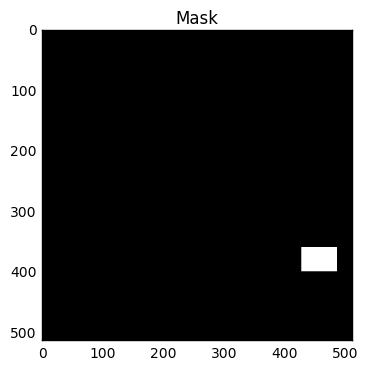

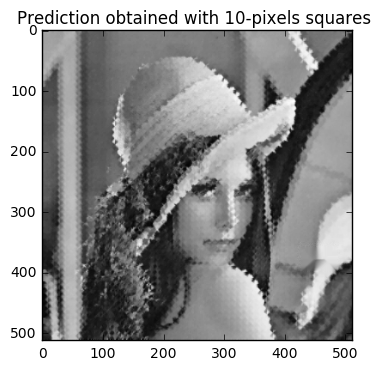

In [22]:
plt.imshow(arr,cmap='gray')
plt.title('Original image')
plt.show()
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.show()
plt.imshow(test.prediction,cmap='gray')
plt.title('Prediction obtained with 10-pixels squares ')

In [23]:
##PROBLEM WITH COBRA - PREDICT ONLY 1D - SHOULD ADAPT THE SOURCE CODE


#Adapt pixel and color value for the COBRA code
X_training=[]
Y_training=[]
X_test=[]
for j in range(arr.shape[0]):
    for k in range(arr.shape[1]):
        if mask[j,k]!=255 :
            X_training.append(np.array([j,k]))
            Y_training.append(arr[j,k])
        else :
            X_test.append(np.array([j,k]))
            

In [24]:
from pycobra.cobra import Cobra
from pycobra.diagnostics import Diagnostics
COBRA = Cobra(random_state=0, epsilon=0.5)
COBRA.fit(X_training, Y_training, default=False)


Cobra(epsilon=0.5, machines=None, random_state=0)

In [25]:
COBRA = Cobra(random_state=0, epsilon=10)

COBRA.fit(X_training, Y_training, default=False)
COBRA.load_machine( 'CVNS', Inpaintingmachines(inpaint=cv2.INPAINT_NS).fit(arr,mask,10))

COBRA.load_machine('CVTELEA', Inpaintingmachines(inpaint=cv2.INPAINT_TELEA).fit(arr,mask,10))
COBRA.split_data()

Cobra(epsilon=10, machines=None, random_state=0)

In [26]:
COBRA.load_machine_predictions()
queries=[]
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i,j]!=0 :
            queries.append([[i,j]])


In [27]:
query=[[0,0]]
print(arr[0,0],COBRA.predict(query),len(queries))

(162, array([ 159.]), 2360)


In [28]:
cobra_prediction=[]
for j in range(len(queries)) :
    if j%300==0 :
        print(float(j)/len(queries))
    cobra_prediction.append(COBRA.predict(queries[j]))

0.0
0.127118644068
0.254237288136
0.381355932203
0.508474576271
0.635593220339
0.762711864407
0.889830508475


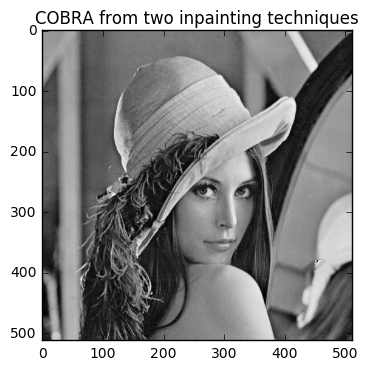

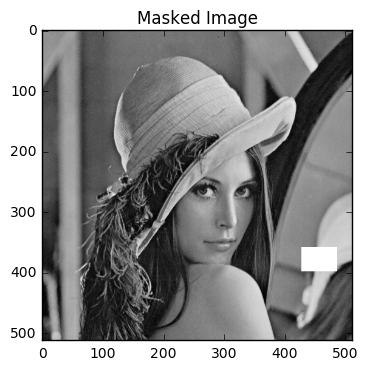

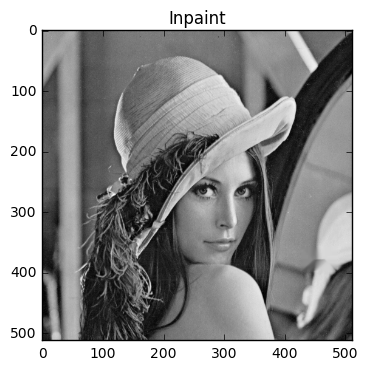

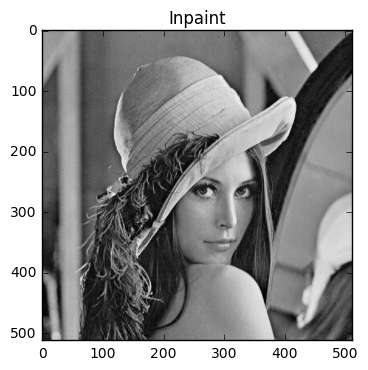

In [85]:
##Reconstruct
newimage=np.copy(arr)
for j in range(len(queries)) :
    newimage[queries[j][0][0],queries[j][0][1]]=cobra_prediction[j]
plt.imshow(newimage,cmap='gray')
plt.title('COBRA from two inpainting techniques')
plt.show()
arrmasked=np.copy(arr)
for j in range(len(rects)) :
    arrmasked[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]]=np.array(255,dtype=np.uint8)
plt.imshow(arrmasked,cmap='gray')
plt.title('Masked Image')
plt.show()
dst=cv2.inpaint(arr,mask,3,cv2.INPAINT_NS)
plt.imshow(dst,cmap='gray')
plt.title('Inpaint')
plt.show()
dst=cv2.inpaint(arr,mask,3,cv2.INPAINT_TELEA)
plt.imshow(dst,cmap='gray')
plt.title('Inpaint')
plt.show()

2360

In [31]:
len(queries)

2360

In [32]:
queries[0]

[[359, 427]]

In [34]:
b=np.copy(cobra_prediction)